# 1. Library

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# ✅ 1. Nâng pip
%pip install -q -U pip

# ✅ 2. Cài toàn bộ stack Hugging Face + eval + Arrow
%pip install -q \
  "transformers>=4.44,<5.0.0" \
  "accelerate" \
  "sentencepiece" \
  "evaluate>=0.4.2" \
  "rouge-score" \
  "pyarrow>=21.0.0" \
  "datasets>=4.1.0" \
  "huggingface_hub>=0.34.0,<1.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incom

In [3]:
# datasets
from datasets import (
    load_dataset,
    Dataset,
    DatasetDict,
    load_from_disk,
)

# transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    TrainerCallback,
)
from transformers.trainer_utils import get_last_checkpoint

# libs khác
import numpy as np
import evaluate
import json
import shutil
import pandas as pd
import torch

# để kiểm tra version & làm việc với Arrow
import datasets
import pyarrow
import transformers

2025-12-01 02:56:11.660201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764557771.881308      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764557771.947438      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# 2. Load dataset 

In [4]:
ds = load_dataset("lndat18/augmented_data_sumarization")

README.md:   0%|          | 0.00/577 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.50M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.47M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13443 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1681 [00:00<?, ? examples/s]

In [5]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

# 3. Preprocess

In [6]:
def clean_text(text: str) -> str:
  # xoá xuống dòng thừa, thay _ bằng khoảng trắng…
  text = text.replace("\n", " ").replace("\r", " ")
  text = text.replace("_", " ")

  return " ".join(text.split())

In [7]:
def preprocess_batch(batch):
  batch['article'] = [clean_text(t) for t in batch['article']]
  batch['abstract'] = [clean_text(t) for t in batch['abstract']]

  return batch

In [8]:
# Nếu train trên kaggle thì tắt comment mấy dòng được comment nha

train_ds_clean = train_ds.map(
    preprocess_batch,
    batched=True,
    # cache_file_name="/kaggle/working/train_clean.arrow",
    # load_from_cache_file=False, 
)

val_ds_clean = val_ds.map(
    preprocess_batch,
    batched=True,
    # cache_file_name="/kaggle/working/val_clean.arrow",
    # load_from_cache_file=False,
)

test_ds_clean = test_ds.map(
    preprocess_batch,
    batched=True,
    # cache_file_name="/kaggle/working/test_clean.arrow",
    # load_from_cache_file=False,
)

Map:   0%|          | 0/13443 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1681 [00:00<?, ? examples/s]

# 4. Load model

In [9]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

# 5. Tokenize input (artical) & target (abstract)

In [10]:
# Đo độ dài token cho article

def measure_article_len(batch):
  tokens = tokenizer(
      batch['article'],
      truncation=False,
      add_special_tokens=True
  )
  lengths = [len(ids) for ids in tokens['input_ids']]
  return {"article_len": lengths}


train_with_len = train_ds_clean.map(
    measure_article_len,
    batched=True,
    batch_size=256
)

lens = np.array(train_with_len["article_len"])
print("ARTICLE tokens:")
print("  min :", lens.min())
print("  max :", lens.max())
print("  mean:", lens.mean())
print("  95% :", np.percentile(lens, 95))
print("  99% :", np.percentile(lens, 99))

Map:   0%|          | 0/13443 [00:00<?, ? examples/s]

ARTICLE tokens:
  min : 39
  max : 2368
  mean: 503.96332663839917
  95% : 1125.0
  99% : 1416.1599999999999


In [11]:
# Đo độ dài token cho abstract
def measure_abstract_len(batch):
  with tokenizer.as_target_tokenizer():
    tokens = tokenizer(
        batch['abstract'],
        truncation=False,
        add_special_tokens=True
    )
  lengths = [len(ids) for ids in tokens['input_ids']]
  return {"abstract_len": lengths}


train_with_len2 = train_ds_clean.map(
    measure_abstract_len,
    batched=True,
    batch_size=256
)

abs_lens = np.array(train_with_len2["abstract_len"])
print("ABSTRACT tokens:")
print("  min :", abs_lens.min())
print("  max :", abs_lens.max())
print("  mean:", abs_lens.mean())
print("  95% :", np.percentile(abs_lens, 95))
print("  99% :", np.percentile(abs_lens, 99))

Map:   0%|          | 0/13443 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


ABSTRACT tokens:
  min : 2
  max : 225
  mean: 50.24109201815071
  95% : 113.0
  99% : 133.0


In [12]:
max_input_length = 1024
max_target_length = 128

In [13]:
def tokenize_batch(batch):
  inputs = batch['article']
  targets = batch['abstract']

  model_inputs = tokenizer(
      inputs,
      max_length=max_input_length,
      truncation=True
  )

  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [14]:
cols_to_remove = ["abstract", "article"]

train_tok = train_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)

val_tok = val_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)

test_tok = test_ds_clean.map(
    tokenize_batch,
    batched=True,
    remove_columns=cols_to_remove,
)


Map:   0%|          | 0/13443 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1681 [00:00<?, ? examples/s]

# 6. Data collator

In [15]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)

# 7. Metric

In [16]:
# Load metric ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels


def compute_metrics(eval_pred):
    """
    1) Nhận preds, labels (token ids hoặc logits).
    2) Chuyển logits -> token ids nếu cần.
    3) Thay -100 bằng pad_token_id cho cả preds và labels.
    4) Decode sang text.
    5) Tính ROUGE.
    """
    preds, labels = eval_pred

    # 1. Nếu Trainer trả về (logits, ...) thì lấy phần đầu
    if isinstance(preds, tuple):
        preds = preds[0]

    # 2. Nếu là logits 3D: (batch, seq_len, vocab) -> argmax sang token ids
    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)

    # 3. Ép kiểu về int64 cho chắc
    preds  = preds.astype(np.int64)
    labels = labels.astype(np.int64)

    # 4. Thay -100 bằng pad_token_id cho CẢ HAI
    preds  = np.where(preds  != -100, preds,  tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # 5. Decode từ token IDs sang chuỗi
    decoded_preds  = tokenizer.batch_decode(preds,  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 6. Làm sạch text (strip)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # 7. Tính ROUGE
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,   # tiếng Việt có thể set False nếu muốn
    )

    result = {
        "rouge1": round(rouge_result["rouge1"] * 100, 2),
        "rouge2": round(rouge_result["rouge2"] * 100, 2),
        "rougeL": round(rouge_result["rougeL"] * 100, 2),
    }
    return result


# 8. TrainingArguments & Trainer

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/outputs",

    eval_strategy="epoch",   # eval sau mỗi epoch
    save_strategy="epoch",         # lưu checkpoint sau mỗi epoch

    logging_strategy="steps",
    logging_steps=200,             # 200 step log 1 lần (loss, lr,...)

    learning_rate=5e-5,
    per_device_train_batch_size=2,   # nếu OOM thì giảm xuống 1
    per_device_eval_batch_size=2,
    num_train_epochs=10,           
    weight_decay=0.01,

    predict_with_generate=True,      # dùng generate() khi eval (cần cho ROUGE/BLEU)

    fp16=True,                       # GPU hỗ trợ thì bật

    save_total_limit=2,              # chỉ giữ lại 2 checkpoint gần nhất

    # ĐỂ EARLY STOPPING HOẠT ĐỘNG ĐẸP
    load_best_model_at_end=True,     # sau khi train xong load lại model tốt nhất
    metric_for_best_model="rougeL",  # metric dùng để chọn “best”
    greater_is_better=True,          # rougeL càng cao càng tốt

    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.0036,  # phải tăng >= 0.036 rougeL mới gọi là "improve"
        )
    ],
)

/tmp/ipykernel_47/3081747714.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
output_dir = training_args.output_dir
last_ckpt = get_last_checkpoint(output_dir)

if last_ckpt is not None:
    print(f"Found last checkpoint: {last_ckpt}")

    # Đọc trạng thái trainer từ checkpoint
    state_path = os.path.join(last_ckpt, "trainer_state.json")
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)

    last_epoch = state.get("epoch", None)
    global_step = state.get("global_step", None)

    print(f"Lần trước dừng ở epoch: {last_epoch}")
    print(f"Global step: {global_step}")

    # Tiếp tục train từ checkpoint này
    print("Trainer device:", trainer.args.device)
    trainer.train(resume_from_checkpoint=last_ckpt)
    
else:
    print("Không tìm thấy checkpoint, train từ đầu.")
    print("Trainer device:", trainer.args.device)
    trainer.train()



Found last checkpoint: /kaggle/working/outputs/checkpoint-60498
Lần trước dừng ở epoch: 9.0
Global step: 60498
Trainer device: cuda:0


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [21]:
# output_dir = training_args.output_dir
# last_ckpt = get_last_checkpoint(output_dir)

# 1) Đọc trainer_state.json từ last checkpoint
state_path = os.path.join('/kaggle/working/outputs/checkpoint-60498', "trainer_state.json")
with open(state_path, "r", encoding="utf-8") as f:
    state = json.load(f)

log_history = state["log_history"]

# 2) Đưa vào DataFrame
df_logs = pd.DataFrame(log_history)

# 3) Lọc những dòng là EVAL (có eval_loss)
df_eval = df_logs[df_logs["eval_loss"].notna()].copy()

# 4) Chọn các cột quan trọng và reset index cho đẹp
summary = df_eval[[
    "epoch",
    "eval_loss",
    "eval_rouge1",
    "eval_rouge2",
    "eval_rougeL",
]].reset_index(drop=True)

# 5) In kết quả
print(summary.to_string(index=False))

 epoch  eval_loss  eval_rouge1  eval_rouge2  eval_rougeL
   1.0   1.951309        46.53        21.09        32.30
   2.0   1.950319        45.90        20.54        31.56
   3.0   1.976115        46.47        21.13        32.05
   4.0   2.078673        46.58        21.25        32.18
   5.0   2.191667        46.73        21.35        32.10
   6.0   2.384694        46.75        21.61        32.22
   7.0   2.563152        46.37        21.04        31.90
   8.0   2.755209        46.41        21.01        31.87
   9.0   2.969282        46.38        21.04        31.92


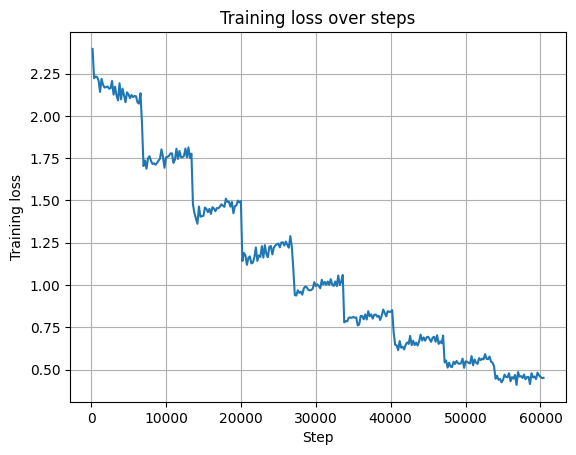

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Lọc entry có key "loss"
train_logs = [e for e in log_history if "loss" in e and "eval_loss" not in e]
df_train = pd.DataFrame(train_logs)

# df_train thường có các cột như: ["loss", "learning_rate", "epoch", "step"]

plt.plot(df_train["step"], df_train["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()


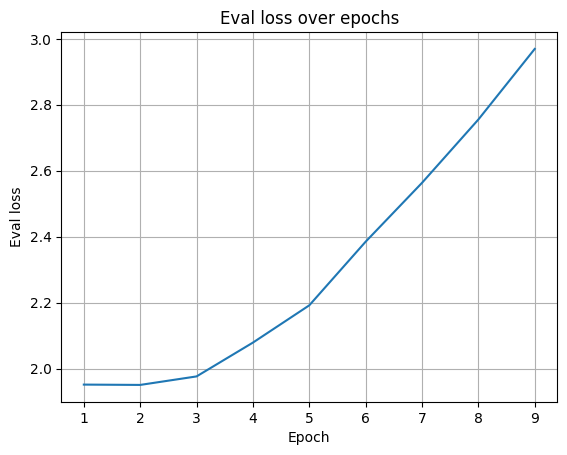

In [23]:
eval_logs = [e for e in log_history if "eval_loss" in e]
df_eval = pd.DataFrame(eval_logs)

plt.plot(df_eval["epoch"], df_eval["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Eval loss")
plt.title("Eval loss over epochs")
plt.grid(True)
plt.show()

# 9. Save best model and push into huggingface

In [24]:
!pip install -q "pyarrow>=21.0.0" "huggingface_hub>=0.24.0"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
import pyarrow
print("pyarrow:", pyarrow.__version__)

pyarrow: 22.0.0


In [27]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_sumarization")

In [ ]:
from huggingface_hub import login

login(token=secret_value_0)

In [ ]:
best_model = trainer.state.best_model_checkpoint
print(best_model)

In [ ]:
# take best model
# tạo thêm 1 folder để lưu riêng nha, sợ nhầm lẫn
best_dir = "/kaggle/working/vit5-vietnews_small_augmented_data"

trainer.save_model(best_dir)        # lưu best model (weights + config)
tokenizer.save_pretrained(best_dir) # lưu tokenizer

print("Best model saved to:", best_dir)


In [ ]:
# Đặt tên repo trên Hugging Face (đổi myusername thành username HF của bạn)
repo_id = "lndat18/vit5-vietnews_small_augmented_data"

# Load lại best model từ thư mục
model_to_push = AutoModelForSeq2SeqLM.from_pretrained(best_dir)
tokenizer_to_push = AutoTokenizer.from_pretrained(best_dir)

# Đẩy lên Hugging Face Hub
model_to_push.push_to_hub(repo_id)
tokenizer_to_push.push_to_hub(repo_id)

print("Pushed to HF repo:", repo_id)


# 10. Evaluate

In [28]:
test_ds = load_dataset("lndat18/augmented_data_sumarization")['test']

In [29]:
# take self fine-tune model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("lndat18/vit5-vietnews_small_augmented_data")
model = AutoModelForSeq2SeqLM.from_pretrained("lndat18/vit5-vietnews_small_augmented_data")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(device)

cuda


In [31]:
test_sample = test_ds[0]
test_article = test_sample['article']
test_abstract = test_sample['abstract']

print(test_article)
print('-'*50)
print(test_abstract)

Trên con đường tìm kiếm một cuộc sống hài hòa giữa hai yếu tố quan trọng nhất của cuộc đời – công việc và cuộc sống cá nhân, không có ai là ngoại lệ. Tuy nhiên, trong thế kỷ mới, công nghệ đã mở ra một loạt cơ hội, mang lại cho dân văn phòng một phương án đáng kinh ngạc. Đầu tiên, hãy xem xét đến hệ thống quản trị thời gian. Thông qua ứng dụng di động như Todoist hay Google Tasks, bạn có thể đặt mục tiêu cụ thể cho từng giờ mỗi ngày, giúp bạn tập trung vào công việc mà vẫn đảm bảo được nhu cầu thiết yếu trong cuộc sống. Bên cạnh đó, kế hoạch trước những nhiệm vụ
--------------------------------------------------
Trong thế kỷ 21, cuộc sống ngày càng bận rộn với công việc hàng ngày và áp lực từ công ty khiến nhiều người cảm thấy bị phân tâm. Tuy nhiên, cách tiếp cận hiện đại cho phép họ tạo ra một "khuôn mặt" cân bằng giữa công việc và cuộc sống. Bài báo này sẽ giới thiệu các mẹo để chúng ta làm hài lòng cả công việc lẫn cuộc sống.


In [32]:
def summarize_text(text, max_input_len=1024, max_new_tokens=512):
    inputs = tokenizer(
        text,
        max_length=max_input_len,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True,
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [33]:
pred = summarize_text(test_article)
print(pred)

Trong thế giới hiện đại, việc quản lý thời gian hiệu quả không chỉ giúp cải thiện chất lượng cuộc sống mà còn nâng cao nhận thức về trách nhiệm và trách nhiệm cá nhân. Bài viết này sẽ chia sẻ những kinh nghiệm quý giá từ những người làm việc trong lĩnh vực công nghệ.


## Evaluate by ROUGE

In [34]:
import evaluate

rouge = evaluate.load("rouge")


In [35]:
max_input_len = 1024   
max_new_tokens = 512    
batch_size = 8

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def generate_batch(batch):
    # batch["article"] là list các string
    inputs = tokenizer(
        batch["article"],
        max_length=max_input_len,
        truncation=True,
        padding="longest",
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True,
            # có thể thêm no_repeat_ngram_size=3 nếu muốn đỡ lặp
        )

    preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    # trả về 1 dict chứa list, datasets sẽ tự gắn thêm cột mới
    return {"pred_summary": preds}


In [36]:
test_pred = test_ds.map(
    generate_batch,
    batched=True,
    batch_size=batch_size,
)


Map:   0%|          | 0/1681 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
preds = test_pred["pred_summary"]
refs  = test_pred["abstract"]

results = rouge.compute(
    predictions=preds,
    references=refs,
    use_stemmer=True,
)


In [ ]:
for key, value in results.items():
    print(f"{key}: {value:.4f}")


# Evaluate by Gemini

In [ ]:
# ! pip install --upgrade openai
! pip install -U google-genai

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Gemini_API_key")


In [ ]:
# Lấy đúng 5 mẫu ngẫu nhiên để gửi lên GPT
small_ds = test_pred.shuffle(seed=42).select(range(5))
eval_df = small_ds.to_pandas()

print(eval_df.columns)
eval_df

In [ ]:
import json
import time
import pandas as pd

from google import genai
from google.genai import types

# ================== CONFIG GEMINI CLIENT ==================

GEMINI_API_KEY = secret_value_0  # hoặc os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=GEMINI_API_KEY)

MODEL_NAME = "gemini-2.5-flash"  # tuỳ bạn chọn model


# ================== SYSTEM PROMPT ==================

SYSTEM_PROMPT = """
You are a strict and reliable evaluator for Vietnamese news summarization.
Your task is to evaluate the QUALITY of a candidate summary given:
(1) the original news article, and
(2) a reference summary written by a human.

You must rate the candidate summary on the following criteria from 1 to 5:
- relevance
- coherence
- fluency
- factuality
Also provide an overall score from 1 to 5.

Use this rubric:
- 1 = very poor, 3 = acceptable/medium, 5 = excellent.

Think step by step, then output ONLY a valid JSON object with the following fields:
{
  "relevance": int,
  "coherence": int,
  "fluency": int,
  "factuality": int,
  "overall": int,
  "short_explanation_vi": "one or two sentences in Vietnamese explaining the scores"
}
Do not output anything else.
"""


# ================== HÀM GỌI GEMINI ==================

def call_judge_api(article: str, ref: str, cand: str) -> str | None:
    """
    Gọi Gemini để chấm 1 sample, trả về chuỗi JSON (string).
    Trả về None nếu có lỗi khi trích xuất text.
    """
    user_prompt = f"""
[INSTRUCTION]
Evaluate the following candidate summary.

[ORIGINAL_ARTICLE]
{article}

[REFERENCE_SUMMARY]
{ref}

[CANDIDATE_SUMMARY]
{cand}

Now provide your JSON evaluation.
"""

    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=user_prompt,
        config=types.GenerateContentConfig(
            system_instruction=SYSTEM_PROMPT,
            temperature=0.0,
            max_output_tokens=256,
            # Bắt buộc model trả JSON
            response_mime_type="application/json",
        ),
    )

    # ---- Cách 1: dùng response.text (SDK mới hỗ trợ) ----
    raw = getattr(response, "text", None)

    # ---- Nếu response.text trống thì fallback sang ghép từ candidates ----
    if not raw:
        try:
            parts = []
            for cand_obj in response.candidates or []:
                content = getattr(cand_obj, "content", None)
                if not content or not getattr(content, "parts", None):
                    continue
                for part in content.parts:
                    # phần text nằm trong part.text
                    if hasattr(part, "text") and part.text:
                        parts.append(part.text)
            raw = "".join(parts) if parts else None
        except Exception as e:
            print("[Error] Cannot extract text from response:", e)
            return None

    if raw is None:
        print("[Warning] call_judge_api: response text is None")
    return raw


# ================== HÀM RETRY ==================

def judge_one_with_retry(
    article: str,
    ref: str,
    cand: str,
    max_retries: int = 5,
    base_sleep: int = 20
):
    """
    Gọi Gemini với retry + exponential backoff khi bị lỗi quota/rate-limit.
    Trả về dict score nếu OK, None nếu bỏ qua sample.
    """
    last_raw = None

    for attempt in range(max_retries):
        try:
            raw = call_judge_api(article, ref, cand)
            last_raw = raw

            # Quan trọng: nếu call_judge_api trả None thì không parse JSON nữa
            if raw is None:
                print("[Warning] call_judge_api returned None, skip this sample.")
                return None

            scores = json.loads(raw.strip())
            return scores

        except genai.errors.ClientError as e:
            # Lỗi từ server (bao gồm rate-limit, quota,...)
            msg = str(e)
            if "429" in msg or "RESOURCE_EXHAUSTED" in msg:
                wait = base_sleep * (2 ** attempt)  # 20, 40, 80, ...
                print(f"[RateLimit] {msg} -> sleeping {wait} seconds... (attempt {attempt+1})")
                time.sleep(wait)
                continue
            else:
                print("[Error] Gemini ClientError (non-retriable):", msg)
                return None

        except json.JSONDecodeError:
            print("[Warning] JSON decode error, raw output:")
            print(last_raw)
            return None

    print("[Error] Max retries exceeded, skipping this sample.")
    return None

In [ ]:
# ================== VÒNG LẶP CHẤM TOÀN BỘ eval_df ==================

# eval_df: DataFrame gốc có cột ["article", "abstract", "pred_summary"]
# Bạn đã có eval_df sẵn; ở đây mình chỉ dùng lại:

results = []

for idx, row in eval_df.iterrows():
    print(f"=== Evaluating sample {idx} ===")
    article = row["article"]
    ref = row["abstract"]
    cand = row["pred_summary"]

    scores = judge_one_with_retry(article, ref, cand)
    if scores is None:
        # Có thể log thêm nếu muốn
        continue

    scores["idx"] = idx
    results.append(scores)

eval_scores = pd.DataFrame(results)
print(eval_scores.columns)
print(eval_scores.head())

# Nếu muốn lưu ra csv:
# eval_scores.to_csv("eval_scores_gemini.csv", index=False)